# Setup

## Imports

In [535]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import re
from typing import List

In [536]:
plt.rcParams["font.family"] ="NanumGothic"
plt.rcParams["axes.unicode_minus"] =False

In [537]:
# Logger config
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

In [538]:
train_df = pd.read_csv("./input/processed/train_df_imputed.csv")
test_df = pd.read_csv("./input/processed/test_df_imputed.csv")
station_info_processed = pd.read_csv("./input/processed/station_info_processed.csv")

In [539]:
train_df.head()

,id,station,station_name,date,cloud_cover_0,cloud_cover_1,cloud_cover_10,cloud_cover_11,cloud_cover_12,cloud_cover_13,...,wind_speed_23,wind_speed_3,wind_speed_4,wind_speed_5,wind_speed_6,wind_speed_7,wind_speed_8,wind_speed_9,climatology_temp,target
0,0,98,동두천,01-01,0.0,0.0,9.0,0.0,3.0,3.0,...,2.3,0.6,0.3,0.7,0.6,0.7,0.8,0.1,-2.707143,-3.992857
1,1,98,동두천,01-02,0.0,0.0,0.0,0.0,0.0,0.0,...,0.7,0.2,0.0,1.1,1.3,0.5,0.9,0.4,-3.646429,-1.653571
2,2,98,동두천,01-03,0.0,0.0,0.0,0.0,0.0,0.0,...,0.4,1.5,0.8,0.8,0.9,1.0,1.1,0.1,-2.694643,-0.005357
3,3,98,동두천,01-04,0.0,0.0,2.0,0.0,0.0,1.0,...,0.9,0.3,0.5,0.2,0.5,1.3,0.5,0.2,-2.501786,-0.898214
4,4,98,동두천,01-05,0.0,0.0,0.0,0.0,0.0,0.0,...,1.4,1.1,1.6,1.4,1.8,0.5,1.1,0.6,-2.625000,-1.775000


## Helper Functions

In [540]:
def pipe(df, func, *args, **kwargs):
    """Allows df.pipe(func, *args, **kwargs) for our custom funcs."""
    return func(df, *args, **kwargs)

In [541]:
def extract_time_feature_bases(df: pd.DataFrame) -> List[str]:
    time_cols = [col for col in df.columns if re.match(r".+_\d{1,2}$", col)]
    return sorted({col.rsplit("_", 1)[0] for col in time_cols})


In [542]:
def check_nan(df: pd.DataFrame) -> int:
    return df.isna().sum().sum()

# Feature Engineering

In [543]:
def merge_with_station_data(df: pd.DataFrame, station_df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()

    output = output.merge(station_df, on='station', how='left')
    output = output.drop(columns=['station', 'station_name'])

    return output

In [544]:
def date_column_handler(df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()

    # Convert string to datetime(with consideration of leap years, making them all to be in 2024) for future use
    if df['date'].dtype == object:
        output['date'] = pd.to_datetime('2024-' + df['date'], format='%Y-%m-%d', errors='coerce')

    # Note)
    # Model might falsely interpret the valuse as ordinal or linear(i.e., it may think Febulary is "twice as big" as Jan!)
    # So we are converting them into sin/cos
    # +) considering our target: the next day's temperature anomaly, therefore we would better to use sin/cos for day of year(doy)!
    # We use both sin/cos -> since we want to uniquely represent any position on a cycle! therefore we need 2D coords

    doy = output['date'].dt.dayofyear
    # Dataset is including the leap year -> so we use the average year length(if other better ideas, please post them at the PR!!)
    output['doy_sin'] = np.sin(2 * np.pi * doy / 365)
    output['doy_cos'] = np.cos(2 * np.pi * doy / 365)

    # solar declination δ (radians)
    δ = np.deg2rad(23.44) * np.sin(2 * np.pi * (doy - 81) / 365.0)
    φ = np.deg2rad(output['lat'].values)
    # hour angle at sunrise ω₀ = arccos(−tanφ⋅tanδ)
    ω0 = np.arccos(-np.tan(φ) * np.tan(δ))
    # day length in hours = 2·ω₀·(180/π)/15
    day_len = 2 * ω0 * (180.0/np.pi) / 15.0
    output['day_length'] = day_len

    output = output.drop(columns=['date', 'lat'])

    return output

In [545]:
def engineer_dew_humidity_features(df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()
    dew_cols = [f'dew_point_{h}' for h in range(24)]
    hum_cols = [f'humidity_{h}'  for h in range(24)]
    if set(dew_cols).issubset(output.columns) and set(hum_cols).issubset(output.columns):
        output['dew_point_avg'] = output[dew_cols].mean(axis=1)
        output['humidity_avg'] = output[hum_cols].mean(axis=1)
        output['dew_humidity_interaction'] = output['dew_point_avg'] * output['humidity_avg']
    return output

In [546]:
def engineer_surface_temp_features(df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()
    st_cols = [f"surface_temp_{i}" for i in range(24)]
    dp_cols = [f"dew_point_{i}"   for i in range(24)]
    if not (set(st_cols) <= set(output.columns) and set(dp_cols) <= set(output.columns)):
        return output

    arr_t  = output[st_cols].values
    arr_dp = output[dp_cols].values

    output["surface_temp_avg"] = arr_t.mean(axis=1)
    if "climatology_temp" in output.columns:
        output["surface_temp_anomaly"] = (
            output["surface_temp_avg"] - output["climatology_temp"]
        )

    periods = {
        "night": slice(0,  6),
        "morning": slice(6, 12),
        "afternoon": slice(12,18),
        "evening": slice(18,24),
    }
    for name, sl in periods.items():
        t = arr_t[:, sl].mean(axis=1)
        d = arr_dp[:, sl].mean(axis=1)
        output[f"temp_{name}_avg"] = t
        output[f"dp_{name}_avg"] = d
        output[f"dew_depression_{name}"] = t - d
        output[f"temp_dp_interaction_{name}"] = t * d

    return output

In [547]:
def engineer_pressure_features(df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()
    slp_cols = [f'sea_level_pressure_{h}' for h in range(24)]
    if set(slp_cols).issubset(output.columns):
        output['pressure_tendency'] = output[slp_cols[-1]] - output[slp_cols[0]]
        output['slp_avg'] = output[slp_cols].mean(axis=1)
    return output

In [548]:
def engineer_interaction_features(df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()
    epsilon = 1e-6

    # Foundational
    output['diurnal_range_am_pm'] = output['temp_afternoon_avg'] - output['temp_morning_avg']
    output['temp_afternoon_minus_night_avg'] = output['temp_afternoon_avg'] - output['temp_night_avg'] # TANA
    output['temp_evening_minus_night_avg'] = output['temp_evening_avg'] - output['temp_night_avg'] # TEMNA
    output['harmonic_tana_temna'] = (2 * output['temp_afternoon_minus_night_avg'] * output['temp_evening_minus_night_avg']) / (output['temp_afternoon_minus_night_avg'] + output['temp_evening_minus_night_avg'] + epsilon)
    output['dew_depression_change_day_progress'] = output['dew_depression_afternoon'] - output['dew_depression_morning']

    output['seasonal_pressure_tendency_sin'] = output['pressure_tendency'] * output['doy_sin'] # spts
    output['seasonal_pressure_tendency_cos'] = output['pressure_tendency'] * output['doy_cos'] # sptc

    # Basic Polynomials/Ratios
    output['pressure_tendency_sq'] = output['pressure_tendency'] ** 2
    output['STA_sq'] = output['surface_temp_anomaly'] ** 2
    output['ratio_slp_avg_div_pressure_tendency'] = output['slp_avg'] / (output['pressure_tendency'] + epsilon)

    # Helpers for seasonal squares
    output['doy_sin_sq'] = output['doy_sin'] ** 2
    output['doy_cos_sq'] = output['doy_cos'] ** 2

    # --- Core Interactions ---
    # Humidity and Dew Depression(HumDew)
    output['humidity_avg_x_dew_depression_morning'] = output['humidity_avg'] * output['dew_depression_morning'] # HumDewMorn
    output['humidity_avg_x_dew_depression_evening'] = output['humidity_avg'] * output['dew_depression_evening'] # HumDewEve
    output['ratio_hum_dew_morn_div_hum_dew_eve'] = output['humidity_avg_x_dew_depression_morning'] / (output['humidity_avg_x_dew_depression_evening'] + epsilon)

    output['climatology_temp_x_doy_sin'] = output['climatology_temp'] * output['doy_sin']
    output['climatology_temp_x_doy_cos'] = output['climatology_temp'] * output['doy_cos']

    # Sea Level Pressure(SLP)
    # output['slp_avg_x_daylen_X_humidity_avg'] = output['slp_avg'] * output['day_length'] * output['humidity_avg']

    output['dp_evening_avg_X_doy_sin'] = output['dp_evening_avg'] * output['doy_sin']
    output['dp_evening_avg_X_doy_cos'] = output['dp_evening_avg'] * output['doy_cos']

    # Critical Surface Temp Anomaly(STA) interaction
    output['STA_x_slp_avg'] = output['surface_temp_anomaly'] * output['slp_avg']

    output['pressure_tendency_sq_X_clim_doy_cos'] = output['pressure_tendency_sq'] * output['climatology_temp_x_doy_cos']

    # output['diff_clim_doy_sin_cos'] = output['climatology_temp_x_doy_sin'] - output['climatology_temp_x_doy_cos']

    # --- Peak Complexity Patterns(got R² 0.7862) ---

    # A) _X_doy_SQ patterns
    # output['climatology_temp_x_doy_sin_sq'] = output['climatology_temp'] * output['doy_sin_sq']
    # output['climatology_temp_x_doy_cos_sq'] = output['climatology_temp'] * output['doy_cos_sq']
    # output['spts_X_doy_cos_sq'] = output['seasonal_pressure_tendency_sin'] * output['doy_cos_sq']
    # output['diff_clim_doy_sin_cos_X_doy_cos_sq'] = output['diff_clim_doy_sin_cos'] * output['doy_cos_sq']
    # output['diff_clim_doy_sin_cos_X_doy_sin_sq'] = output['diff_clim_doy_sin_cos'] * output['doy_sin_sq']
    output['pt_sq_X_clim_X_doy_sin_sq'] = output['pressure_tendency_sq'] * output['climatology_temp'] * output['doy_sin_sq']

    # Temp_dp_interaction for evening/morning
    output['temp_dp_interaction_evening_X_doy_sin_sq'] = output['temp_dp_interaction_evening'] * output['doy_sin_sq']
    output['temp_dp_interaction_evening_X_doy_cos_sq'] = output['temp_dp_interaction_evening'] * output['doy_cos_sq']
    output['temp_dp_interaction_morning_X_doy_cos_sq'] = output['temp_dp_interaction_morning'] * output['doy_cos_sq']

    output['STA_x_slp_X_doy_sin_sq'] = output['STA_x_slp_avg'] * output['doy_sin_sq']
    output['STA_x_slp_X_doy_cos_sq'] = output['STA_x_slp_avg'] * output['doy_cos_sq']
    # output['STA_raw_X_doy_sin_sq'] = output['surface_temp_anomaly'] * output['doy_sin_sq']

    # B) High-Order Interaction ((Derived_A * slp_avg) * Seasonal_C/SQ_C)
    output['clim_doy_sin_X_slp_avg_base'] = output['climatology_temp_x_doy_sin'] * output['slp_avg']
    output['clim_doy_sin_slp_X_doy_cos'] = output['clim_doy_sin_X_slp_avg_base'] * output['doy_cos']
    # output['dp_eve_doy_cos_slp_X_doy_sin_sq'] = output['dp_evening_avg_X_doy_cos'] * output['slp_avg'] * output['doy_sin_sq']

    # --- Testing ---
    output['elev_X_slp_avg'] = output['elev'] * output['slp_avg']
    output['dp_evening_avg_X_humidity_avg'] = output['dp_evening_avg'] * output['humidity_avg']
    output['elev_slp_avg_X_STA_slp_avg'] = output['elev_X_slp_avg'] * output['STA_x_slp_avg']

    return output

In [549]:
def drop_unused_features(df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()

    # Drop {prefix}_{n}(original) features
    prefixes = extract_time_feature_bases(output)
    drop_cols = [f"{p}_{h}" for p in prefixes for h in range(24)]
    existing = [col for col in drop_cols if col in df.columns]

    output = output.drop(columns=existing)

    return output

In [550]:
def engineer_features(df: pd.DataFrame, station_df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()
    return (
        output
        .pipe(merge_with_station_data, station_df)
        .pipe(date_column_handler)
        .pipe(engineer_dew_humidity_features)
        .pipe(engineer_surface_temp_features)
        .pipe(engineer_pressure_features)
        .pipe(engineer_interaction_features)
        .pipe(drop_unused_features)
    )

In [551]:
train_df = engineer_features(train_df, station_info_processed)
test_df = engineer_features(test_df, station_info_processed)

In [552]:
train_df.shape

(13132, 62)

In [553]:
test_df.shape

(3004, 61)

In [554]:
train_df

,id,climatology_temp,target,elev,doy_sin,doy_cos,day_length,dew_point_avg,humidity_avg,dew_humidity_interaction,...,temp_dp_interaction_evening_X_doy_sin_sq,temp_dp_interaction_evening_X_doy_cos_sq,temp_dp_interaction_morning_X_doy_cos_sq,STA_x_slp_X_doy_sin_sq,STA_x_slp_X_doy_cos_sq,clim_doy_sin_X_slp_avg_base,clim_doy_sin_slp_X_doy_cos,elev_X_slp_avg,dp_evening_avg_X_humidity_avg,elev_slp_avg_X_STA_slp_avg
0,0,-2.707143,-3.992857,115.62,1.721336e-02,0.999852,9.426812,-16.808333,46.875000,-787.890625,...,2.961507e-02,99.920107,127.438895,-8.815410e-01,-2974.285840,-4.820260e+01,-4.819546e+01,119598.773250,-805.468750,-3.558264e+08
1,1,-3.646429,-1.653571,115.62,3.442161e-02,0.999407,9.437325,-17.466667,45.500000,-794.733333,...,1.231096e-01,103.780224,139.827463,-2.595330e+00,-2187.838376,-1.299268e+02,-1.298498e+02,119683.079500,-775.016667,-2.621579e+08
2,2,-2.694643,-0.005357,115.62,5.161967e-02,0.998667,9.448699,-17.645833,43.583333,-769.064236,...,2.693834e-01,100.828117,124.610965,-7.249960e+00,-2713.603741,-1.441104e+02,-1.439183e+02,119787.619250,-808.470833,-3.259246e+08
3,3,-2.501786,-0.898214,115.62,6.880243e-02,0.997630,9.460926,-11.966667,53.166667,-636.227778,...,8.748014e-02,18.392520,95.585368,-6.930954e+00,-1457.218729,-1.775998e+02,-1.771789e+02,119294.789000,-297.733333,-1.746654e+08
4,4,-2.625000,-1.775000,115.62,8.596480e-02,0.996298,9.473997,-15.729167,40.583333,-638.342014,...,8.650343e-01,116.190521,82.468249,-5.823838e+00,-782.251995,-2.319591e+02,-2.311004e+02,118848.688500,-814.372222,-9.366178e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13127,17506,-3.485714,0.785714,80.09,-6.880243e-02,0.997630,9.449241,-5.366667,63.500000,-340.783333,...,6.090789e-03,1.280576,1.179390,1.633184e+01,3433.736677,2.458972e+02,2.453145e+02,82117.611833,-612.775000,2.833114e+08
13128,17507,-2.632143,-0.367857,80.09,-5.161967e-02,0.998667,9.455193,-11.600000,52.333333,-607.066667,...,1.726358e-02,6.461625,26.060374,4.263837e+00,1595.921044,1.396260e+02,1.394399e+02,82303.821083,-415.177778,1.317013e+08
13129,17508,-1.555357,1.055357,80.09,-3.442161e-02,0.999407,9.462014,-11.720833,52.541667,-615.832118,...,1.241786e-02,10.468138,34.207477,2.900412e-01,244.501960,5.490646e+01,5.487392e+01,82137.300625,-471.999306,2.010655e+07
13130,17509,-2.814286,6.614286,80.09,-1.721336e-02,0.999852,9.469701,-5.958333,69.625000,-414.848958,...,-9.958960e-05,-0.336012,10.032304,6.535013e-01,2204.888622,4.974986e+01,4.974249e+01,82250.094042,-280.820833,1.814060e+08


In [555]:
test_df

,id,climatology_temp,elev,doy_sin,doy_cos,day_length,dew_point_avg,humidity_avg,dew_humidity_interaction,surface_temp_avg,...,temp_dp_interaction_evening_X_doy_sin_sq,temp_dp_interaction_evening_X_doy_cos_sq,temp_dp_interaction_morning_X_doy_cos_sq,STA_x_slp_X_doy_sin_sq,STA_x_slp_X_doy_cos_sq,clim_doy_sin_X_slp_avg_base,clim_doy_sin_slp_X_doy_cos,elev_X_slp_avg,dp_evening_avg_X_humidity_avg,elev_slp_avg_X_STA_slp_avg
0,0,24.017857,39.81,-0.835925,-0.548843,12.946233,21.679167,77.416667,1678.328819,26.612500,...,376.064796,162.115204,167.742824,1824.854699,786.664147,-20207.723803,11090.866912,40068.930875,1648.975000,1.046408e+08
1,1,1.778571,30.59,-0.523416,0.852078,9.580320,-5.075000,70.000000,-355.250000,0.387500,...,-0.714285,-1.892937,7.332561,-394.540420,-1045.577869,-963.755157,-821.194105,31668.552417,-288.166667,-4.560646e+07
2,2,24.091071,30.59,-0.111659,-0.993747,14.503336,22.141667,87.666667,1941.086111,27.279167,...,7.998727,633.555440,563.982420,40.045442,3171.880808,-2710.092755,2693.145408,30818.660250,2102.538889,9.898726e+07
3,3,27.076786,30.59,-0.693281,-0.720667,13.466553,25.683333,85.708333,2201.275694,33.554167,...,366.046545,395.536789,415.820726,3139.990350,3392.961133,-18932.873855,13644.300234,30852.436708,2116.995833,2.015575e+08
4,4,7.417857,30.59,0.970064,0.242850,11.832631,-2.470833,60.916667,-150.514931,8.725000,...,-4.642124,-0.290932,-0.720293,1254.776878,78.639551,7340.431083,1782.621649,31204.859000,-43.656944,4.160907e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999,2999,1.932143,39.81,-0.463550,0.886071,9.569618,-7.950000,44.291667,-352.118750,2.841667,...,-0.553313,-2.021687,-13.150779,201.574169,736.508688,-923.768609,-818.524225,41060.034000,-380.170139,3.851771e+07
3000,3000,12.312500,30.59,0.999917,-0.012910,12.458907,-6.066667,53.791667,-326.336111,6.583333,...,-13.861578,-0.002311,-0.004962,-5859.626478,-0.976820,12593.919589,-162.591231,31291.785583,-194.546528,-1.833887e+08
3001,3001,27.073214,39.81,-0.393590,-0.919286,14.094582,18.466667,75.833333,1400.388889,21.850000,...,66.615389,363.401833,298.705282,-807.790074,-4406.675328,-10637.905513,9779.277285,39743.318250,1480.013889,-2.072402e+08
3002,3002,18.208929,39.81,0.642055,-0.766659,14.182867,14.370833,74.958333,1077.213715,25.062500,...,136.807495,195.060838,199.046217,2877.108970,4102.196938,11905.611906,-9127.542367,40540.347625,1125.624306,2.829435e+08


<Axes: >

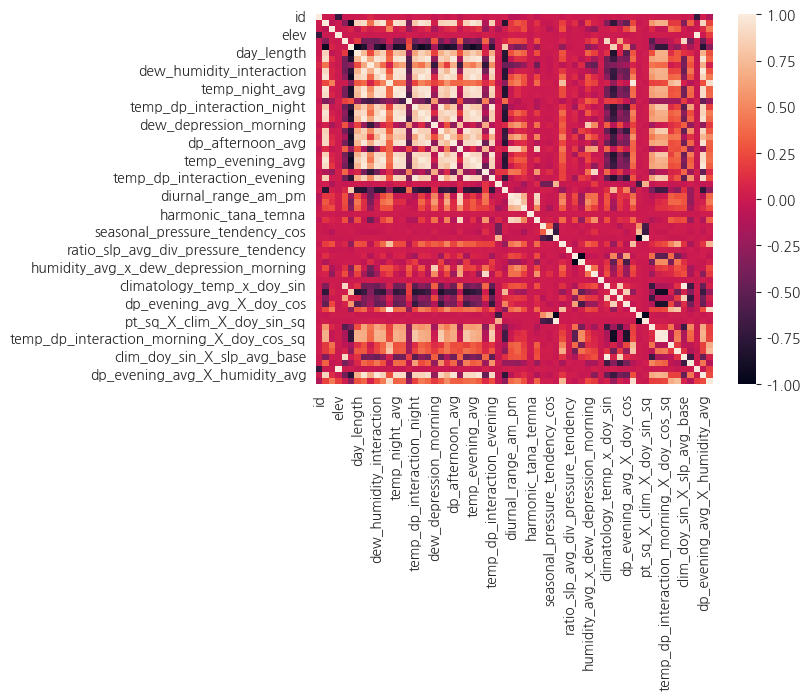

In [556]:
corr = train_df.corr()
sns.heatmap(corr)

> Export

In [557]:
# export df
train_df.to_csv("./input/processed/train_df_final_v5.csv", index=False)
test_df.to_csv("./input/processed/test_df_final_v5.csv", index=False)